In [33]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import SpaGCN as spg
#In order to read in image data, we need to install some package. Here we recommend package "opencv"
#inatll opencv in python
#!pip3 install opencv-python
import cv2

In [34]:
spg.__version__

'1.2.0'

In [35]:
from scanpy import read_10x_h5
adata = read_10x_h5("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_A/outs/filtered_feature_bc_matrix.h5")
spatial=pd.read_csv("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_A/outs/spatial/tissue_positions_list.csv",sep=",",header=None,na_filter=False,index_col=0) 
adata.obs["x1"]=spatial[1]
adata.obs["x2"]=spatial[2]
adata.obs["x3"]=spatial[3]
adata.obs["x4"]=spatial[4]
adata.obs["x5"]=spatial[5]
#Select captured samples
adata=adata[adata.obs["x1"]==1]
adata.var_names=[i.upper() for i in list(adata.var_names)]
adata.var["genename"]=adata.var.index.astype("str")
adata.write_h5ad("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_A/outs/sample_data.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'genename' as categorical


In [36]:
adata=sc.read("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_A/outs/sample_data.h5ad")
img=cv2.imread("/media/chang/HDD-8/chang/new_maldi/AS.tif")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [38]:
adata.obs["x_array"]=adata.obs["x2"]
adata.obs["y_array"]=adata.obs["x3"]
adata.obs["x_pixel"]=adata.obs["x4"]
adata.obs["y_pixel"]=adata.obs["x5"]
x_array=adata.obs["x_array"].tolist()
y_array=adata.obs["y_array"].tolist()
x_pixel=adata.obs["x_pixel"].tolist()
y_pixel=adata.obs["y_pixel"].tolist()

#Test coordinates on the image
img_new=img.copy()
for i in range(len(x_pixel)):
    x=x_pixel[i]
    y=y_pixel[i]
    img_new[int(x-20):int(x+20), int(y-20):int(y+20),:]=0
cv2.imwrite('/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_A/outs/spatial/mapped.jpg', img_new)

res=5
img_new=img.copy()
for i in range(len(x_pixel)):
    x=x_pixel[i]
    y=y_pixel[i]
    img_new[int(x-res):int(x+res), int(y-res):int(y+res),:]=255

cv2.imwrite('/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_A/outs/spatial/test_mapping.jpg', img_new)

True

In [39]:
s=1
b=49
adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, x_pixel=x_pixel, y_pixel=y_pixel, image=img, beta=b, alpha=s, histology=True)
#If histlogy image is not available, SoaGCN can calculate the adjacent matrix using the fnction below
#adj=calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)
np.savetxt('/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_A/outs/adj.csv', adj, delimiter=',')

Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  0.0 0.0 606.8933824680744
Var of x,y,z =  2720369.009340232 5921502.8994199475 5921502.899419946


In [40]:
adata=sc.read("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_A/outs/sample_data.h5ad")
adj=np.loadtxt('/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_A/outs/adj.csv', delimiter=',')
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [42]:
p=0.25
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 187.95337081877315]
Run 2: l [0.01, 500.005], p [0.0, 47.3770399324278]
Run 3: l [0.01, 250.0075], p [0.0, 10.639174530082677]
Run 4: l [0.01, 125.00874999999999], p [0.0, 1.9917059624730475]
Run 5: l [62.509375, 125.00874999999999], p [0.12696134942289072, 1.9917059624730475]
Run 6: l [62.509375, 93.7590625], p [0.12696134942289072, 0.8350478002784665]
Run 7: l [62.509375, 78.13421875], p [0.12696134942289072, 0.41378816932786955]
recommended l =  70.321796875
70.321796875


In [86]:
n_clusters=14
#Set seed
r_seed=t_seed=n_seed=100
#Seaech for suitable resolution
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  12
Initializing cluster centers with louvain, resolution =  0.7999999999999999
Epoch  0
Epoch  10
Res =  0.7999999999999999 Num of clusters =  13
Res changed to 0.7999999999999999
Initializing cluster centers with louvain, resolution =  0.8999999999999999
Epoch  0
Epoch  10
Res =  0.8999999999999999 Num of clusters =  14
recommended res =  0.8999999999999999


In [87]:
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-9, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')
#Do cluster refinement(optional)
#shape="hexagon" for Visium data, "square" for ST data.
adj_2d=spg.calculate_adj_matrix(x=x_array,y=y_array, histology=False)
refined_pred=spg.refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["pred"].tolist(), dis=adj_2d, shape="hexagon")
adata.obs["refined_pred"]=refined_pred
adata.obs["refined_pred"]=adata.obs["refined_pred"].astype('category')
#Save results
adata.write_h5ad("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_A/outs/results.h5ad")

Initializing cluster centers with louvain, resolution =  0.8999999999999999
Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
Epoch  60
delta_label  0.0 < tol  5e-09
Reach tolerance threshold. Stopping training.
Total epoch: 61
Calculateing adj matrix using xy only...


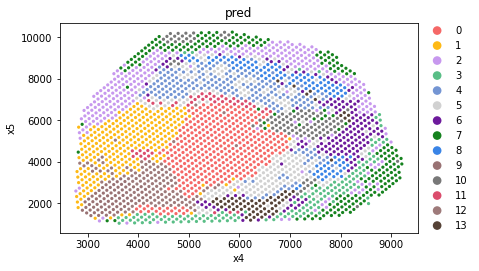

In [88]:
adata=sc.read("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_A/outs/results.h5ad")
#Set colors used
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
#Plot spatial domains
domains="pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="x4",y="x5",color=domains,size=100000/adata.shape[0])
#ax.set_aspect('equal', 'box')
#ax.axes.invert_yaxis()
plt.savefig("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_A/outs/pred.png", dpi=600)
plt.close()

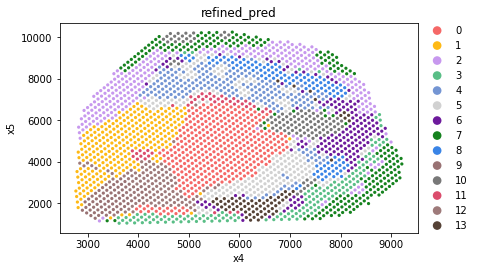

AttributeError: 'NoneType' object has no attribute 'set_aspect'

In [89]:
domains="refined_pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="x4",y="x5",color=domains,title=domains,color_map=plot_color,show=True,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_A/outs/refined_pred.png", dpi=600)
plt.close()

In [90]:
adata.obs.to_csv("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_A/outs/meta.csv", sep=',')

In [91]:
adata = read_10x_h5("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_B/outs/filtered_feature_bc_matrix.h5")
spatial=pd.read_csv("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_B/outs/spatial/tissue_positions_list.csv",sep=",",header=None,na_filter=False,index_col=0) 
adata.obs["x1"]=spatial[1]
adata.obs["x2"]=spatial[2]
adata.obs["x3"]=spatial[3]
adata.obs["x4"]=spatial[4]
adata.obs["x5"]=spatial[5]
#Select captured samples
adata=adata[adata.obs["x1"]==1]
adata.var_names=[i.upper() for i in list(adata.var_names)]
adata.var["genename"]=adata.var.index.astype("str")
adata.write_h5ad("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_B/outs/sample_data.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'genename' as categorical


In [92]:
adata=sc.read("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_B/outs/sample_data.h5ad")
img=cv2.imread("/media/chang/HDD-8/chang/new_maldi/BS.tif")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [93]:
adata.obs["x_array"]=adata.obs["x2"]
adata.obs["y_array"]=adata.obs["x3"]
adata.obs["x_pixel"]=adata.obs["x4"]
adata.obs["y_pixel"]=adata.obs["x5"]
x_array=adata.obs["x_array"].tolist()
y_array=adata.obs["y_array"].tolist()
x_pixel=adata.obs["x_pixel"].tolist()
y_pixel=adata.obs["y_pixel"].tolist()

#Test coordinates on the image
img_new=img.copy()
for i in range(len(x_pixel)):
    x=x_pixel[i]
    y=y_pixel[i]
    img_new[int(x-20):int(x+20), int(y-20):int(y+20),:]=0
cv2.imwrite('/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_B/outs/spatial/mapped.jpg', img_new)

True

In [94]:
s=1
b=49
adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, x_pixel=x_pixel, y_pixel=y_pixel, image=img, beta=b, alpha=s, histology=True)
#If histlogy image is not available, SoaGCN can calculate the adjacent matrix using the fnction below
#adj=calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)
np.savetxt('/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_B/outs/adj.csv', adj, delimiter=',')

Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  0.0 0.0 1269.513017046209
Var of x,y,z =  4156643.6584042353 6750809.689133938 6750809.689133939


In [117]:
n_clusters=8
#Set seed
r_seed=t_seed=n_seed=100
#Seaech for suitable resolution
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-9, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  19
Initializing cluster centers with louvain, resolution =  0.6
Epoch  0
Epoch  10
Res =  0.6 Num of clusters =  15
Res changed to 0.6
Initializing cluster centers with louvain, resolution =  0.5
Epoch  0
Epoch  10
Res =  0.5 Num of clusters =  14
Res changed to 0.5
Initializing cluster centers with louvain, resolution =  0.4
Epoch  0
Epoch  10
Res =  0.4 Num of clusters =  12
Res changed to 0.4
Initializing cluster centers with louvain, resolution =  0.30000000000000004
Epoch  0
Epoch  10
Res =  0.30000000000000004 Num of clusters =  8
recommended res =  0.30000000000000004


In [126]:
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-4, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')
#Do cluster refinement(optional)
#shape="hexagon" for Visium data, "square" for ST data.
adj_2d=spg.calculate_adj_matrix(x=x_array,y=y_array, histology=False)
refined_pred=spg.refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["pred"].tolist(), dis=adj_2d, shape="hexagon")
adata.obs["refined_pred"]=refined_pred
adata.obs["refined_pred"]=adata.obs["refined_pred"].astype('category')
#Save results
adata.write_h5ad("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_B/outs/results.h5ad")

Initializing cluster centers with louvain, resolution =  0.30000000000000004
Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
Epoch  60
Epoch  70
Epoch  80
Epoch  90
Epoch  100
Epoch  110
Epoch  120
Epoch  130
Epoch  140
Epoch  150
Epoch  160
Epoch  170
Epoch  180
Epoch  190
Calculateing adj matrix using xy only...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


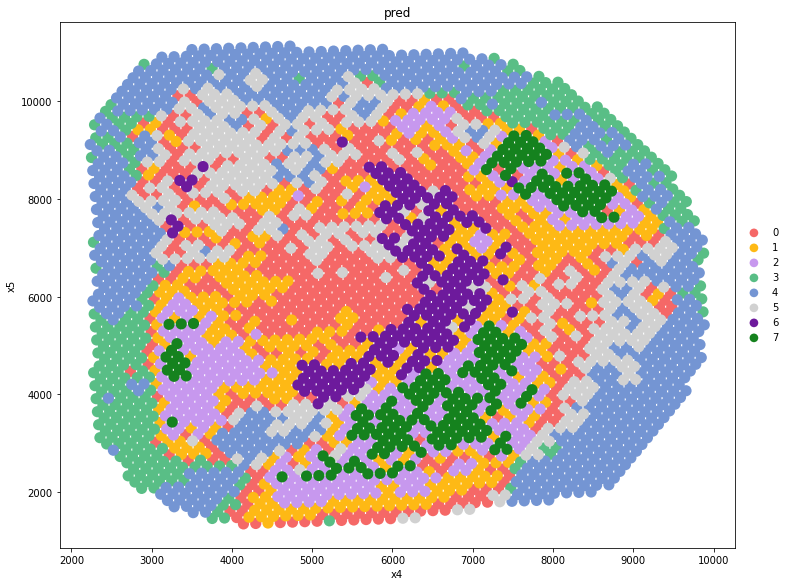

In [127]:
adata=sc.read("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_B/outs/results.h5ad")
plt.rcParams['figure.figsize'] = 10,10
#Set colors used
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
#Plot spatial domains
domains="pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="x4",y="x5",color=domains,size=500)
#ax.set_aspect('equal', 'box')
#ax.axes.invert_yaxis()
plt.savefig("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_B/outs/pred.png", dpi=600)
plt.close()

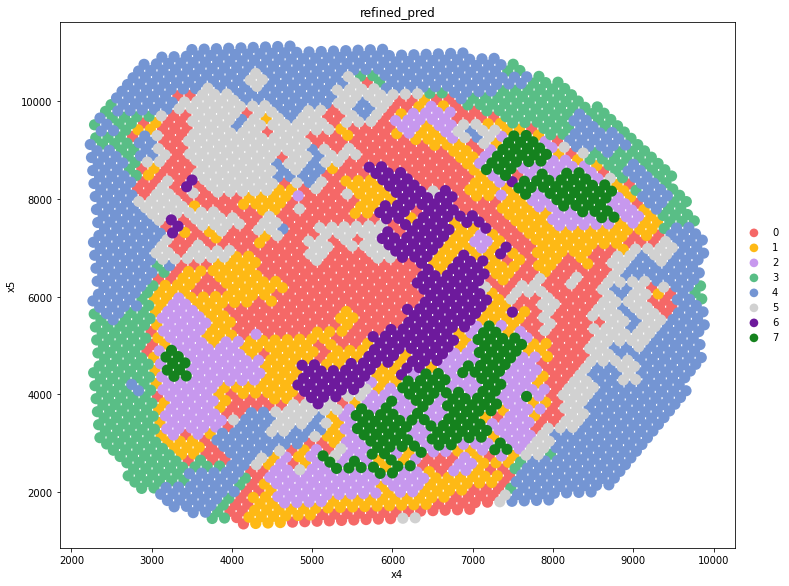

In [128]:
plt.rcParams['figure.figsize'] = 10,10
domains="refined_pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="x4",y="x5",color=domains,title=domains,color_map=plot_color,show=True,size=500)
#ax.set_aspect('equal', 'box')
#ax.axes.invert_yaxis()
plt.savefig("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_B/outs/refined_pred.png", dpi=600)
plt.close()

In [129]:
adata.obs.to_csv("/media/chang/HDD-8/chang/new_maldi/cr_out/Sample_B/outs/meta.csv", sep=',')